# Final Project: Neural network for crowd dynamics
___

This notebook serves as the main file for our implementation part of the review of the paper [Prediction of pedestrian dynamics in complex architectures with artificial neural networks](https://www.tandfonline.com/doi/abs/10.1080/15472450.2019.1621756) from *Tordeaux et al.*. The data-sets from the paper can be found [here](https://zenodo.org/record/1054017).

As we decided to use our own data-sets for training and testing, we created both reference scenarios (*Bottleneck* and *Corridor*) using the [Vadere simulation software](http://www.vadere.org/download/) to simulate them for different scenario parameters.
## Scenarios
|**Corridor Scenario in Vadere**|**Bottleneck Scenario in Vadere**|
|---|---|
|![bild](scenario_creation/corridor/corridor_scenario.png)|![bild](scenario_creation/bottleneck/bottleneck_scenario.png)|

By using the compiled console version of Vadere we were able to set up a complete pipeline including simulation and further data-set usage in python code. For a high level of modularity, we thus outsourced all following implementation steps into independent software modules.
## Software Pipeline
___
The complete pipeline of software components, which are sequentially called in this file, are:<br>
### 1. Scenario Creation
* Implemented in **scenario_creation**
* Here, different versions of each scenarios can be created. Use **create_corridor_scenario.py** to create a corridor scenario with a desried number of pedestrians. Use **create_bottleneck_scenarios.py** to create a bottleneck scenario with a desired number of pedestrians and a desired width of the bottleneck.
### 2. Scenario Simulation
* Implemented in **vadere_simulation**
* Use **simulate_scenarios.py** to simulate all scenario files which are located in a desired folder. The output .txt files are written into **vadere_data_raw**.
### 3. Data Processing
* Implemented in **vadere_preprocessing**
* Use **preprocessing.py** to post-process the resulting raw data from the Vadere simulation. All needed inputs for the neural networks, such as relative positions of K neighbors, are calculated. Additionally, data rows which are not suitable for training are ommitted. The resulting data matrix is saved as a new .pkl file in **vadere_preprocessing**.
### 4. Neural Network Training
* Implemented in **neural_network**
* The network architectures are implemented in this file. Use **create_nn** and **train_nn** to create and train the neural networks.
* The networks are saved to be able to reload them later on
### 5. Reload Networks and Test
* The networks are reloaded within this file
* Use **test_nn** within **neural_network** to calculate MSEs for different test sets
### 6. Result Visualization
* Implemented in this file using methods of **performance_measure**
---

## 0. Imports and Settings needed throughout the project (always execute this cell)

In [1]:
#allow import of software modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#basic imports needed throughout the notebook
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from neural_network.neural_network import create_nn
from neural_network.neural_network import train_nn
from performance_measure.aic import aic_total
from performance_measure.aic import get_number_params
from performance_measure.aic import AIC

#print only errors
tf.get_logger().setLevel('ERROR')

#pedestrian sizes of scenarios
sizes = [15, 30, 60, 85, 95, 110, 140, 230]
#widths of bottlenecks in cm
widths = [70, 95, 120, 180]

## 1. Scenario Creation

### Corridor

In [2]:
from scenario_creation.create_corridor_scenarios import create_corridor_scenario

for i in range(len(sizes)):
    create_corridor_scenario(size=sizes[i], free_flow_speed=1.3849458349162476, pedestrian_radius=0.2, base_file_path='scenario_creation/corridor/corridor.scenario', output_folder_path='scenario_creation/corridor/')

### Bottleneck

In [3]:
from scenario_creation.create_bottleneck_scenarios import create_bottleneck_scenario

for i in range(len(widths)):
    create_bottleneck_scenario(size=150, width=widths[i], free_flow_speed=1.3849458349162476, pedestrian_radius=0.2, base_file_path='scenario_creation/bottleneck/bottleneck.scenario', output_folder_path='scenario_creation/bottleneck/')

## 2. Scenario Simulation

### Corridor

In [4]:
from vadere_simulation.simulate_scenarios import simulate_scenarios_from_folder

simulate_scenarios_from_folder(folder_path='scenario_creation/corridor/', output_folder_path='vadere_data_raw/corridor', print_output=False)

Simulate Scenario File: corridor_015.scenario...
Simulate Scenario File: corridor_230.scenario...
Simulate Scenario File: corridor_110.scenario...
Simulate Scenario File: corridor_030.scenario...
Simulate Scenario File: corridor_060.scenario...
Simulate Scenario File: corridor_085.scenario...
Simulate Scenario File: corridor_140.scenario...
Simulate Scenario File: corridor_095.scenario...


### Bottleneck

In [5]:
from vadere_simulation.simulate_scenarios import simulate_scenarios_from_folder

simulate_scenarios_from_folder(folder_path='scenario_creation/bottleneck/', output_folder_path='vadere_data_raw/bottleneck', print_output=False)

Simulate Scenario File: bottleneck_120.scenario...
Simulate Scenario File: bottleneck_095.scenario...
Simulate Scenario File: bottleneck_070.scenario...
Simulate Scenario File: bottleneck_180.scenario...


## 3. Data processing

### Corridor

In [6]:
from vadere_data_preprocessing.preprocessing import generate_data

#Set Parameters for data preprocessing
K = 10
data_per_scenario = 1000
data_scenarios = []

for i in range(len(sizes)):
    data_scenario = generate_data(scenario="corridor", scenario_specificaton=sizes[i], data_per_scenario=data_per_scenario, K=K)
    data_scenarios.append(data_scenario)

#create corridor data set and save as pkl file
C = pd.concat(data_scenarios).sample(frac=1, random_state = 1).reset_index()
C.to_pickle("vadere_data_preprocessing/C.pkl")
C.head()

,level_0,index,timeStep,pedestrianId,x-PID3,y-PID3,speedInAreaUsingAgentVelocity-PID5,x-rel1,y-rel1,x-rel2,...,u-rel6,v-rel7,u-rel7,v-rel8,u-rel8,v-rel9,u-rel9,v-rel10,u-rel10,s_k
0,740,36652,386,87,11.644062,10.433387,0.333650,-0.532671,0.327378,0.704539,...,0.342108,0.188456,-0.266143,-0.074792,-0.136721,-0.148173,-0.267459,0.493177,0.045699,1.240539
1,606,36196,330,16,10.419086,11.748515,0.692473,-0.295617,-0.451297,0.771268,...,-0.103248,0.026255,0.287272,-0.687841,-0.079963,-0.162137,-0.012645,-0.306797,-0.245352,1.195635
2,824,47469,500,74,11.381285,11.694680,0.667300,0.388028,-0.457801,-0.510946,...,0.365034,0.691427,0.579873,0.277638,0.609107,0.362420,0.567298,0.339234,0.627996,1.183923
3,205,5252,56,37,11.638518,10.716820,0.692473,-0.070845,0.730665,-0.817765,...,-0.706282,-0.104059,-0.522867,-0.047503,-0.435671,0.134090,0.447056,0.423820,-0.349980,1.567629
4,228,47868,564,23,10.286466,11.788371,0.550948,0.688606,-0.294479,-0.747947,...,-0.071262,-0.139923,-0.098696,-0.062607,-0.067175,0.116143,0.045765,-0.410122,-0.884680,1.361353


### Bottleneck

In [7]:
from vadere_data_preprocessing.preprocessing import generate_data

#Set Parameters for data preprocessing
K = 10
data_per_scenario = 2000
data_scenarios = []

for i in range(len(widths)):
    data_scenario = generate_data(scenario = "bottleneck", scenario_specificaton = widths[i], data_per_scenario=data_per_scenario, K=K)
    data_scenarios.append(data_scenario)

#create bottleneck data set and save as pkl file
B = pd.concat(data_scenarios).sample(frac=1, random_state = 1).reset_index()
B.to_pickle("vadere_data_preprocessing/B.pkl")
B.head()

,level_0,index,timeStep,pedestrianId,x-PID3,y-PID3,speedInAreaUsingAgentVelocity-PID5,x-rel1,y-rel1,x-rel2,...,u-rel6,v-rel7,u-rel7,v-rel8,u-rel8,v-rel9,u-rel9,v-rel10,u-rel10,s_k
0,740,14389,114,97,18.182468,8.906421,0.564296,-0.297317,-0.598190,0.388966,...,0.735057,-0.478396,0.290813,-0.241674,0.575721,0.008869,0.376528,0.250863,0.356485,0.935640
1,1606,16761,147,142,21.801660,9.272863,0.505006,-0.002174,-0.571674,-0.450885,...,-0.147002,0.432632,-0.123951,0.169060,-0.129454,-0.518445,-0.147002,-0.286916,-0.141280,0.954876
2,824,8985,63,56,21.316189,9.682793,0.400653,0.605096,-0.050057,-0.410300,...,0.195455,-0.004364,0.240021,0.367993,-0.040559,-0.398028,-0.045790,0.105314,-0.099650,1.094289
3,205,18134,177,104,19.722346,8.769179,0.484373,-0.388878,-0.452738,-0.242291,...,0.247242,0.039269,0.143785,0.054818,-0.079295,0.004637,-0.071006,0.073479,0.095224,1.184929
4,1228,18564,161,52,18.726069,9.125518,0.000000,0.475954,-0.321934,-0.310490,...,-0.077708,0.372797,0.229566,0.146693,-0.070743,0.046103,0.037228,-0.041128,0.034736,0.865015


## 4. Training Neural Networks

### Settings (always execute this cell)

In [2]:
#read both saved datasets
B = pd.read_pickle("vadere_data_preprocessing/B.pkl")
C = pd.read_pickle("vadere_data_preprocessing/C.pkl")

#TODO change to 70 - 10 - 20
data_split_C = [int(len(C)*.7), int(len(C)*.9)] # Train 70%, Validation 20%, Test 10% 
data_split_B = [int(len(B)*.7), int(len(B)*.9)] # Train 70%, Validation 20%, Test 10%

#split data sets for training, validation and testing
C_train, C_validation, C_test = np.split(C, data_split_C)
B_train, B_validation, B_test = np.split(B, data_split_B)

#define architectures as in paper
K=10
epochs = 200
batch_size = None
number_steps_loss_increase = 8
min_improvement = 0.001
# ((NN1), (NN2), (NN3), (NN4)) = ((s_k, v_rel), ...)
inputs_neural_networks = ((False, False), (False, True), (True, False), (True, True))
# ((X/Y), ...) = ((Traindata, Testdata), ...)
data_combinations_train = ('b', 'c', 'bc')
# ((neurons of hidden layer 1), (neurons of hidden layer 2), ...)
architectures = ((1,), (2,), (3,), (4, 2), (5, 2), (5, 3), (6, 3), (10, 4))

### Training

In [5]:
NNi = []
i = 0
for nn_index, input_neural_networks in enumerate(inputs_neural_networks):
    for comb_index, data_combination_train in enumerate(data_combinations_train):
        for arch_index, architecture in enumerate(architectures):
            i += 1
            print("")
            print("-------Training-------: ", i,"/ 96")
            print("NNi - Dataset - Architecture")
            print(nn_index+1, "   ", data_combination_train, "       ", architecture)
            # Initialise neural network
            # NNi[nn_index][comb_index][arch_index]
            nn = create_nn(h=architecture, K=K, s_k=input_neural_networks[0], v_rel=input_neural_networks[1])#nn.summary()
            # Compile neural network
            nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, name='Adam'), loss=tf.keras.losses.MeanSquaredError())
            # Train neural network
            train_nn(nn, data_combination_train, B_train, B_validation, C_train, C_validation, K, batch_size, epochs, number_steps_loss_increase, min_improvement, s_k=input_neural_networks[0], v_rel=input_neural_networks[1])
            
            NNi.append(nn)

NNi = np.reshape(NNi,(4,3,8))


-------Training-------:  1 / 96
NNi - Dataset - Architecture
1     b         (1,)
Epoch 1/200
175/175 [==============================] - 0s 3ms/step - loss: 0.6370 - val_loss: 0.4708
Epoch 2/200
175/175 [==============================] - 0s 1ms/step - loss: 0.3713 - val_loss: 0.2876
Epoch 3/200
175/175 [==============================] - 0s 1ms/step - loss: 0.2407 - val_loss: 0.2033
Epoch 4/200
175/175 [==============================] - 0s 2ms/step - loss: 0.1831 - val_loss: 0.1687
Epoch 5/200
175/175 [==============================] - 0s 1ms/step - loss: 0.1610 - val_loss: 0.1572
Epoch 6/200
175/175 [==============================] - 0s 1ms/step - loss: 0.1538 - val_loss: 0.1540
Epoch 7/200
175/175 [==============================] - 0s 1ms/step - loss: 0.1518 - val_loss: 0.1534
Epoch 8/200
175/175 [==============================] - 0s 974us/step - loss: 0.1514 - val_loss: 0.1533
Epoch 9/200
175/175 [==============================] - 0s 1ms/step - loss: 0.1513 - val_loss: 0.1533
Epoch 

### Save trained Neural Networks

In [14]:
i = 1
for nn in NNi.flatten():
    name = 'neural_network/models/NNi_'+str(i)+'.pb'
    nn.save(name)
    i += 1

INFO:tensorflow:Assets written to: neural_network/models/NNi_1.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_2.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_3.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_4.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_5.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_6.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_7.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_8.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_9.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_10.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_11.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_12.pb\assets
INFO:tensorflow:Assets written to: neural_network/models/NNi_13.pb\assets
INFO:tensorflow:Assets written to: neural_netwo

### Load saved trained Neural Networks (always execute this cell)

In [3]:
NNi = []
for i in range(96):
    name = 'neural_network/models/NNi_'+str(i+1)+'.pb'
    model = keras.models.load_model(name)
    NNi.append(model)
    i += 1

NNi = np.reshape(NNi,(4,3,8))

### Testing (always execute these cells)

In [4]:
#set train / test combinations
train_test_sets = [['C', 'C'], ['B', 'B'], ['C', 'B'], ['B', 'C'], ['C+B', 'C'], ['C+B', 'B'], ['C+B', 'C+B']]

In [5]:
#calculate MSE using test set
from neural_network.neural_network import test_nn

B_C_test = pd.concat([B_test, C_test]).sample(frac=1, random_state = 1)
input_data_idxs = np.arange(0,4)
testing_NNs = np.arange(0, 8)

error_values_testing = []

for input_data_idx in input_data_idxs:
    error_values_NN_id = []
    for NN_id in testing_NNs:
        results = test_nn(NNi, input_data_idx, NN_id, train_test_sets, B_test, C_test, B_C_test, K)
        error_values_NN_id.append(results)
    error_values_testing.append(error_values_NN_id)
    
error_values_testing = np.array(error_values_testing)

In [7]:
#calculate MSE using training set
from neural_network.neural_network import test_nn

B_C_train = pd.concat([B_train, C_train]).sample(frac=1, random_state = 1)
input_data_idxs = np.arange(0,4)
testing_NNs = np.arange(0, 8)

error_values_training = []

for input_data_idx in input_data_idxs:
    error_values_NN_id = []
    for NN_id in testing_NNs:
        results = test_nn(NNi, input_data_idx, NN_id, train_test_sets, B_train, C_train, B_C_train, K)
        error_values_NN_id.append(results)
    error_values_training.append(error_values_NN_id)

error_values_training = np.array(error_values_training)

In [6]:
#calculate MSE using Weidmann
from performance_measure.weidmann import test_weidmann

error_values_weidmann = test_weidmann(train_test_sets, B_test, C_test, B_C_test)

### Recreate Plots of Paper

#### Figure 6 - Training and Testing Errors on the full Data Set (C+B/C+B)

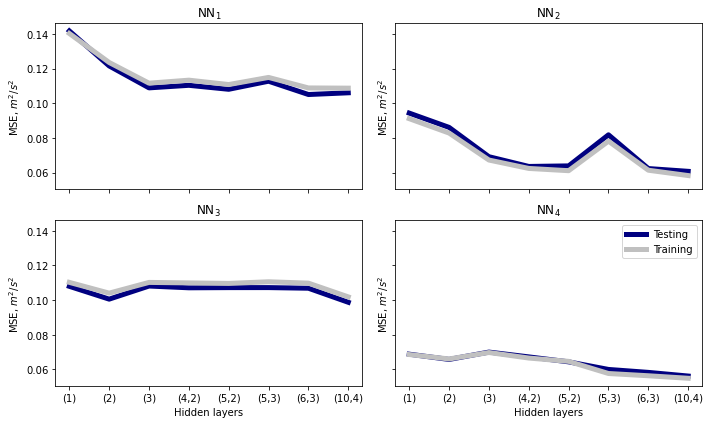

In [9]:
#get MSEs of last experiment
train_mse = error_values_training[:, :, 6]
test_mse = error_values_testing[:, :, 6]

architectures_labels = []
for i in range(len(architectures)):
    if len(architectures[i]) == 1:
        architectures_labels.append("("+str(architectures[i][0])+")")
    else:
        architectures_labels.append("("+str(architectures[i][0])+","+str(architectures[i][1])+")")


#plot train and test loss for each NN
fig, ax = plt.subplots(2,2,figsize=(10,6), sharey=True, sharex=True)
for i in range(2):
    for j in range(2):
        #plot test mse
        ax[i][j].plot(architectures_labels, test_mse[2*i+j], linewidth=5, c='navy', label='Testing')
        #plot train mse
        ax[i][j].plot(architectures_labels, train_mse[2*i+j], linewidth=5, c='silver', zorder=3, label='Training')
        ax[i][j].set_title("NN$_{"+str(2*i+j+1)+"}$")
        ax[i][j].set_ylabel("MSE, $m^2/s^2$")
plt.legend()
ax[1][0].set_xlabel("Hidden layers")
ax[1][1].set_xlabel("Hidden layers")
plt.tight_layout()
plt.savefig("figures/figure_6.png")

#### Figure 11 - Testing error for the optimal complexity for each of the four neural networks and Weidmann Error

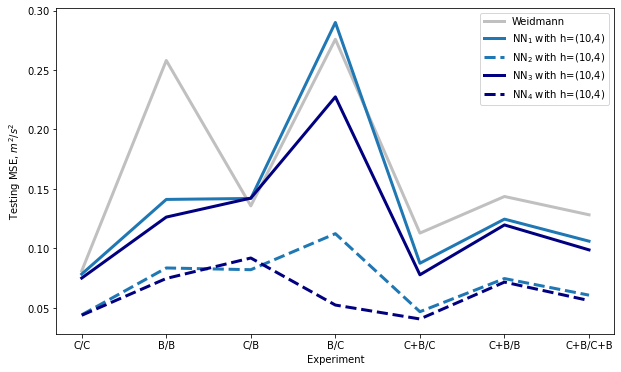

In [10]:
#get labels of experiments for plotting
experiment_labels = []
for i in range(len(train_test_sets)):
    experiment_labels.append(""+train_test_sets[i][0]+"/"+train_test_sets[i][1]+"")

plt.figure(figsize=(10,6))
plt.plot(experiment_labels, error_values_weidmann, linewidth=3, c='silver', label='Weidmann')
plt.plot(experiment_labels, error_values_testing[0][7], linewidth=3, c='tab:blue', label='NN$_{1}$ with h=(10,4)')
plt.plot(experiment_labels, error_values_testing[1][7], linewidth=3, c='tab:blue', ls='--', label='NN$_{2}$ with h=(10,4)' )
plt.plot(experiment_labels, error_values_testing[2][7], linewidth=3, c='navy', label='NN$_{3}$ with h=(10,4)')
plt.plot(experiment_labels, error_values_testing[3][7], linewidth=3, c='navy', ls='--', label='NN$_{4}$ with h=(10,4)')
plt.ylabel("Testing MSE, $m^2/s^2$")
plt.xlabel("Experiment")
plt.legend()
plt.savefig("figures/figure_11.png")

#### Figure 4 - Pedestrian speeds as functions of the mean spacing and respective fitting for the Weidmann model

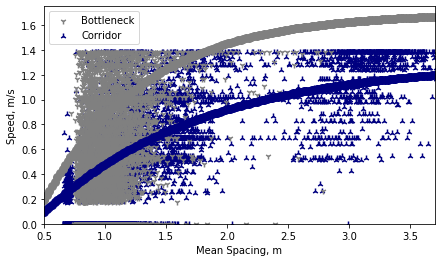

In [11]:
from performance_measure.weidmann import calculate_corridor_speed,calculate_bottleneck_speed

# set figure size
plt.figure(figsize=(7,4))
# calculate values of speeds
range_mean_spacing = np.linspace(0.5, 3.7, 150)
speeds_corridor = calculate_corridor_speed(range_mean_spacing)
speeds_bottleneck = calculate_bottleneck_speed(range_mean_spacing)

data_string = np.array(["s_k"])
b_data = B.loc[:, data_string].to_numpy()
b_v = B['speedInAreaUsingAgentVelocity-PID5'].to_numpy()
c_data = C.loc[:, data_string].to_numpy()
c_v = C['speedInAreaUsingAgentVelocity-PID5'].to_numpy()

# plot visualization
plt.scatter(range_mean_spacing, speeds_corridor, color='navy', linewidth=3.0, zorder=2)
plt.scatter(range_mean_spacing, speeds_bottleneck, color='grey', linewidth=3.0, zorder=2)
plt.scatter(b_data, b_v, color='grey', label='Bottleneck', marker="1", zorder=1)
plt.scatter(c_data, c_v, color='navy', label='Corridor', marker="2", zorder=0)
plt.xlabel('Mean Spacing, m')
plt.ylabel('Speed, m/s')
plt.xlim(0.5, 3.7)
plt.ylim(0.)
plt.legend()
plt.savefig("figures/figure_4.png")

#### Figure 7,8,9,10 - Testing error for the Weidmann's model and the neural networks 1,2,3,4

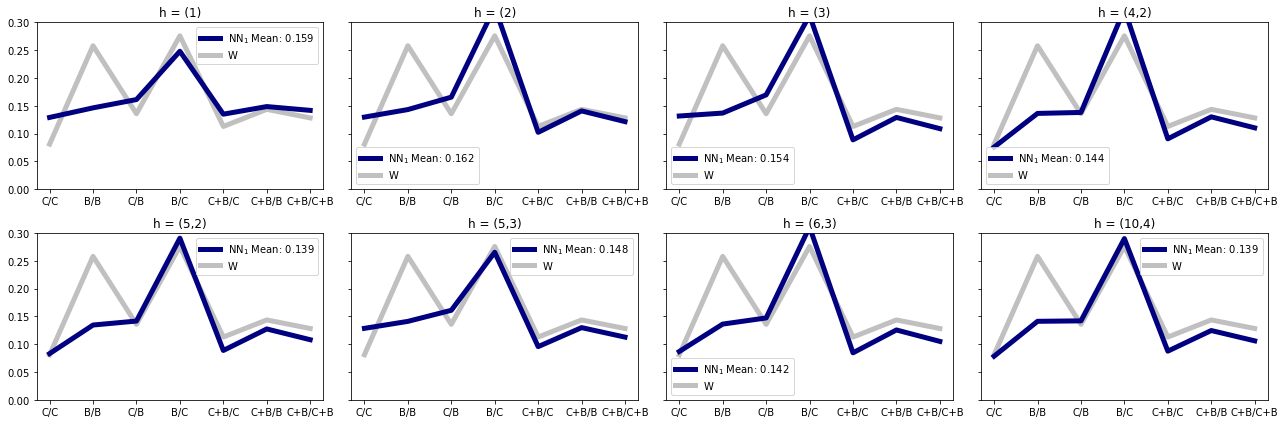

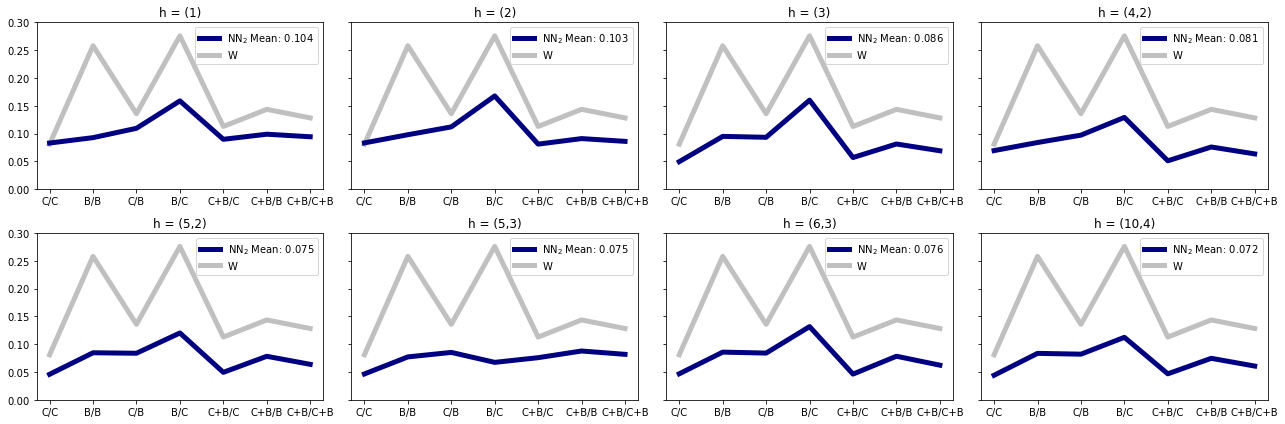

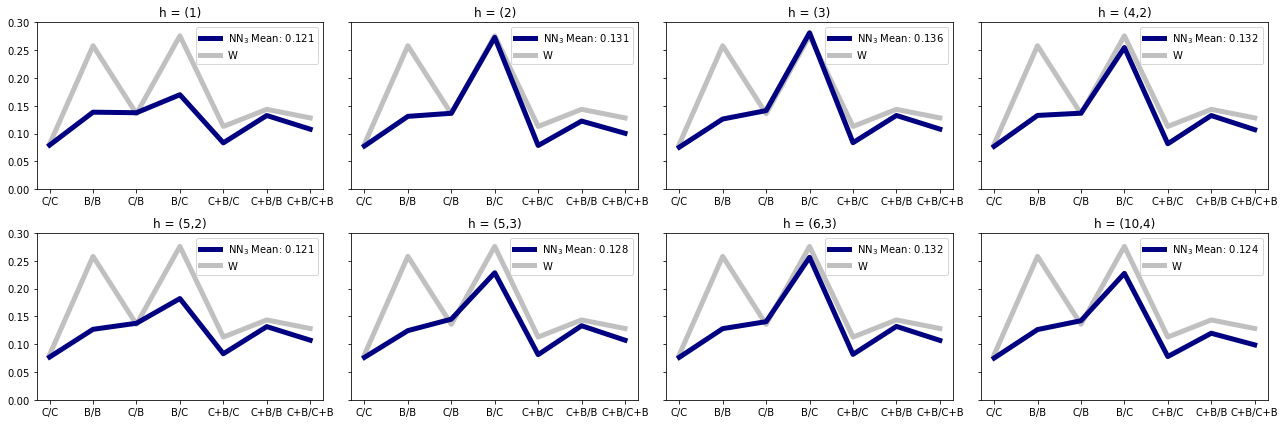

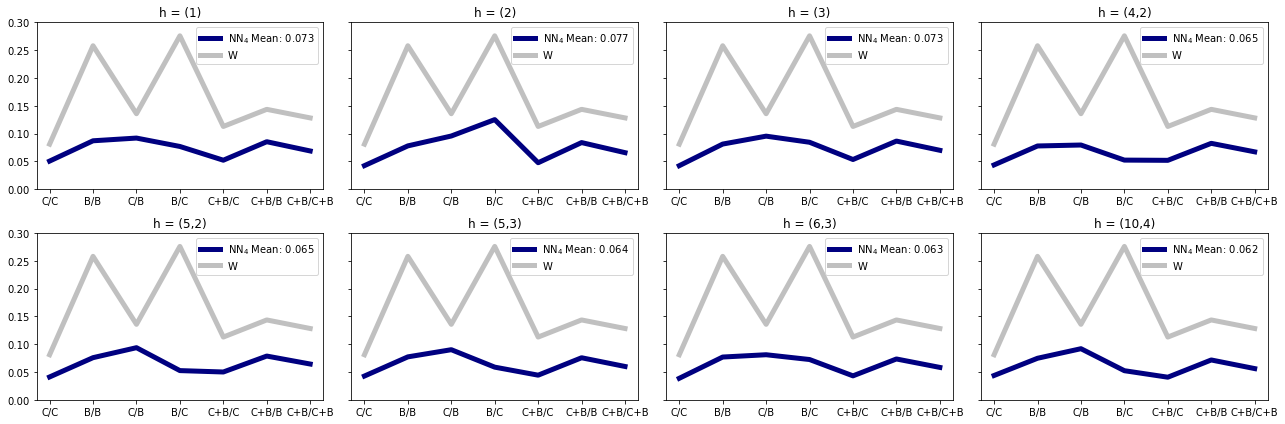

In [16]:
#get labels of experiments for plotting
experiment_labels = []
for i in range(len(train_test_sets)):
    experiment_labels.append(""+train_test_sets[i][0]+"/"+train_test_sets[i][1]+"")

architectures_labels = []
for i in range(len(architectures)):
    if len(architectures[i]) == 1:
        architectures_labels.append("h = ("+str(architectures[i][0])+")")
    else:
        architectures_labels.append("h = ("+str(architectures[i][0])+","+str(architectures[i][1])+")")

network_labels = []
for i in range(len(inputs_neural_networks)):
    network_labels.append("NN$_{"+str(i+1)+"}$")

#plot all hidden layer architectures for one NN in one plot
for n in range(len(inputs_neural_networks)):
    
    fig, ax = plt.subplots(2,4,figsize=(18,6), sharey=True)
    for i in range(2):
        for j in range(4):
            MSEs = error_values_testing[n][4*i + j]
            #calculate also mean MSE
            mean_MSE = np.mean(MSEs)
            #plot NN MSE
            ax[i][j].plot(experiment_labels, MSEs, linewidth=5, c='navy', label=network_labels[n]+" Mean: "+str(round(mean_MSE,3)), zorder=3)
            #calculate weidmann
            weidmannMSEs = error_values_weidmann
            #plot weidmann MSE
            ax[i][j].plot(experiment_labels, weidmannMSEs, linewidth=5, c='silver', label='W')
            ax[i][j].legend()
            ax[i][j].set_ylim(0.0,0.3)
            ax[i][j].set_title(architectures_labels[4*i + j])
    plt.tight_layout()
    fig.savefig("figures/figure_"+str(7+n)+".png")

#### Figure 13 - AIC differences of the neural networks to the AIC of the Weidmanns model

In [7]:
optimal_indices = (7, 7, 7, 7)
n = 8000
training_set = [1, 0, 1, 0, 2, 2, 2] # 'b':=0, 'c':=1, 'bc':=2

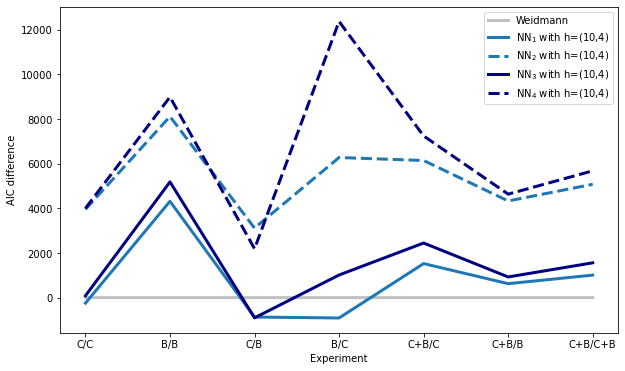

In [9]:
# calculate aic vector
aic_values = aic_total( optimal_indices=optimal_indices, n=n, training_set=training_set, NNi=NNi, error_values_testing=error_values_testing, error_values_weidmann=error_values_weidmann)
#get labels of experiments for plotting
experiment_labels = []
for i in range(len(train_test_sets)):
    experiment_labels.append(""+train_test_sets[i][0]+"/"+train_test_sets[i][1]+"")

plt.figure(figsize=(10,6))
plt.plot(experiment_labels, error_values_weidmann, linewidth=3, c='silver', label='Weidmann')
plt.plot(experiment_labels, aic_values[0], linewidth=3, c='tab:blue', label='NN$_{1}$ with h=(10,4)')
plt.plot(experiment_labels, aic_values[1], linewidth=3, c='tab:blue', ls='--', label='NN$_{2}$ with h=(10,4)' )
plt.plot(experiment_labels, aic_values[2], linewidth=3, c='navy', label='NN$_{3}$ with h=(10,4)')
plt.plot(experiment_labels, aic_values[3], linewidth=3, c='navy', ls='--', label='NN$_{4}$ with h=(10,4)')
plt.ylabel("AIC difference")
plt.xlabel("Experiment")
plt.legend()
plt.savefig("figures/figure_13.png")